MobileNet

*Dense Layer* + odblokowane ostatnie warstwy MobileNet'u --> w pozostałych warstwach wagi pozostają stałe.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Params
img_size = 224
batch_size = 32
num_classes = 10

# Paths
train_dir = r"C:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\project_data\train_spectrograms"
test_dir = r"C:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\project_data\test_spectrograms"

# Train/val generators (80/20 split)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


print("Train:")
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("Val:")
val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (no split)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Test:")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Train:
Found 640 images belonging to 10 classes.
Val:
Found 159 images belonging to 10 classes.
Test:
Found 200 images belonging to 10 classes.


MobileNetV2, GlobalAvaragePooling2D + Dense Layer at the end

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import os


# Model setup
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)        # Flatten conv output
x = Dense(128, activation='relu')(x)   # Optional dense layer
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision()])

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

# Save model
name_model="models/mobilenet_added_dense.keras"
model.save(name_model)

# Test evaluation
print("\nTesting -------------------------------")
results = model.evaluate(test_generator)

# Indeksy: [0] = loss, [1] = accuracy, [2] = precision
test_loss = results[0]
test_acc = results[1]
test_precision = results[2]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Precision: {test_precision:.2%}")


c:\Users\jakub\Desktop\muzyka_guiio\Music-Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.4077 - loss: 1.6865 - precision: 0.6956 - val_accuracy: 0.2075 - val_loss: 4.1571 - val_precision: 0.1915
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.8150 - loss: 0.6059 - precision: 0.8610 - val_accuracy: 0.2013 - val_loss: 6.6606 - val_precision: 0.2092
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.9295 - loss: 0.2628 - precision: 0.9429 - val_accuracy: 0.1384 - val_loss: 12.3705 - val_precision: 0.1329
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9358 - loss: 0.1804 - precision: 0.9517 - val_accuracy: 0.1572 - val_loss: 12.4038 - val_precision: 0.1529
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.9530 - loss: 0.1777 - precision: 0.9568 - val_accuracy: 0.2516 - val_loss: 8.6780 - val_precision: 0.2583
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.9455 - loss: 0.1522 - precision: 0.9585 - val_accuracy: 0.2704 - val_loss: 9.5984

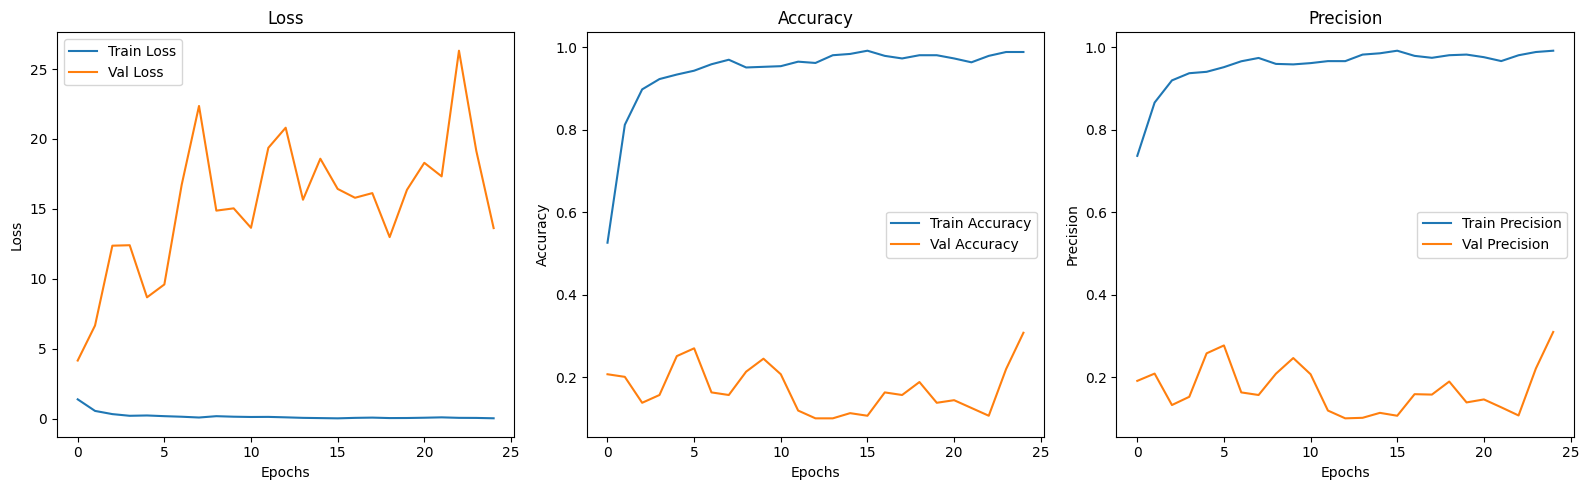

In [3]:
from mobilenet_utils import plot_training_history

plot_training_history(history)

Classification report  + Confusion matrix

5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step


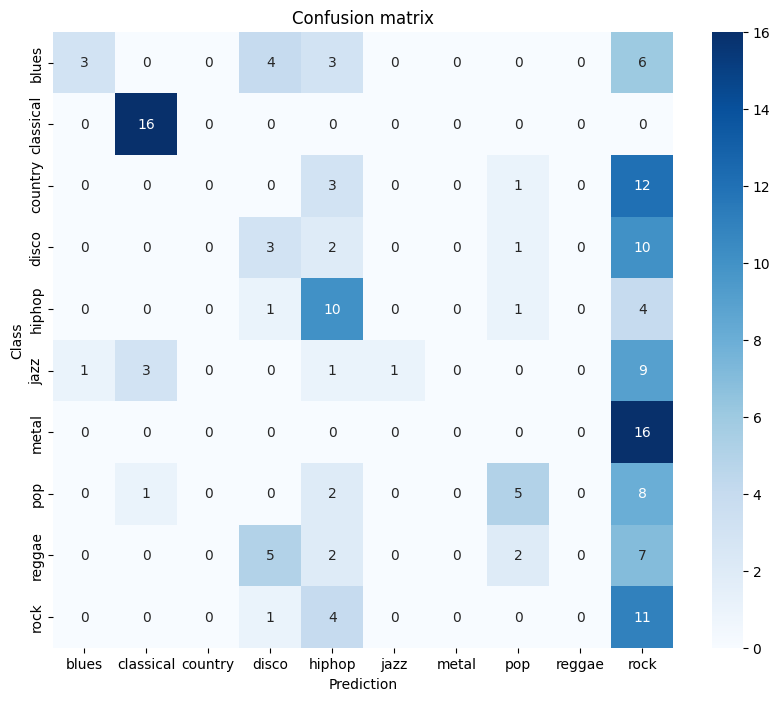

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import numpy as np

# Generujemy predykcje
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Prawdziwe etykiety
y_true = val_generator.classes

# Nazwy klas
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Prediction")
plt.ylabel("Class")
plt.title("Confusion matrix")
plt.show()

**Wnioski:**
- dalej słabe wyniki - otwarcie ostatnich zmian najprawdopodobniej nie jest poprawnym krokiem na drodze optymalizacji tej sieci.